In [2]:
import settle
import viability
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numpy import savetxt
import numpy as np
import math

import module_weather
import module_initsize
import module_covidstats
import module_riskfactor
import viability

mode_to_test = 'speaking' # enter 'speaking','coughing', or 'breathing'

T_range = [5.0,10,15,20,25,30,35]
RH_range = [10,20,30,40,50,60,70,80,90]

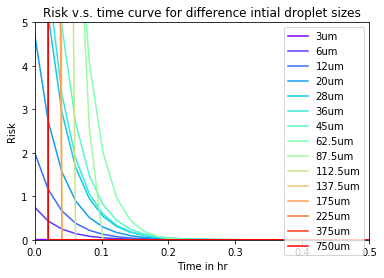

0.5559313563598882


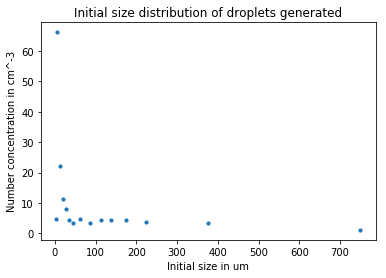

In [3]:
viralload = 10**8 # 10**8 particles per mL, converted to particles per cubic micrometers, assume all viable
T = 40
RH = 80
if mode_to_test == 'speaking':
    [sizeclass,numcon,t_settle,sizepeak,t_peak] = module_initsize.speaking(T,RH)
    NaCl_con = 80.0/1000; # 80.0 mmol/L converted to mol/L for saliva, from Kallapur et al.
elif mode_to_test == 'coughing':
    [sizeclass,numcon,t_settle,sizepeak,t_peak] = module_initsize.coughing(T,RH)
    NaCl_con = 91.0/1000; # Didn't find any data on dry cough droplet sodium level, here I assume it's close to mouth breathing?
elif mode_to_test == 'breathing':
    [sizeclass,numcon,t_settle,sizepeak,t_peak] = module_initsize.breathing(T,RH)

colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(sizeclass)))
viab_hl = []
totalcon = np.sum(numcon)
risk_fac = 0

for binnum in range(len(sizeclass)):
    c = colors[binnum]
    size = sizeclass[binnum]
    count = numcon[binnum]
    dropvol = 4/3 * np.pi*((size/2)**3) * (10**(-12)) # droplet volume converted to mL
    poi_lambda = viralload * dropvol # in viral particles per droplet
    decay_rate = viability.kdecay(T,RH,1.9)
    if size > 10:
        settling_time = settle.settling_time(T,RH,size,NaCl_con,1.5,model='empirical_big')
    else:
        settling_time = settle.settling_time(T,RH,size,NaCl_con,1.5,model='empirical_small')
    halflife = math.log(2)/decay_rate # in hr
    tspan = np.linspace(0,1,50)
    viable_numcon = count*poi_lambda* np.exp(- decay_rate * tspan * 60) # average viral load for a certain droplet size
    viable_numcon_10min = count*poi_lambda* np.exp(- decay_rate * (1/6) * 60)
    risk = viable_numcon * np.maximum((1-(tspan/settling_time)),0) # calculate the time-dependent risk curve 
    risk_10min = viable_numcon_10min * np.maximum(1-((1/6)/settling_time),0)
    risk_fac = risk_fac + risk_10min # sum up the risk factors for a total risk at this T and RH condition
    plt.plot(tspan,risk,color=c, label=str(size)+str('um'))
    viab_hl.append(halflife)
plt.title("Risk v.s. time curve for difference intial droplet sizes")
plt.axis([0, 0.5, 0, 5])
plt.xlabel('Time in hr')
plt.ylabel('Risk')
plt.legend(loc="upper right")
plt.show()
print(risk_fac)
    
plt.title("Initial size distribution of droplets generated")
plt.scatter(sizeclass,numcon,s=10)
plt.xlabel('Initial size in um')
plt.ylabel('Number concentration in cm^-3')
plt.show()

    

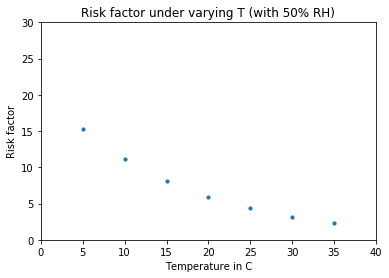

In [4]:
riskfac_array = []
for condT in range(len(T_range)): # Study the effect of varying temperature with fixed RH at 50% 
    T = T_range[condT]
    RH = 50
    risk_T = module_riskfactor.riskfactor(T,RH,mode_to_test)
    riskfac_array.append(risk_T)
plt.scatter(T_range, riskfac_array, s=10 )
plt.axis([0, 40, 0, 30])
plt.title("Risk factor under varying T (with 50% RH)")
plt.xlabel('Temperature in C')
plt.ylabel('Risk factor')
plt.show()

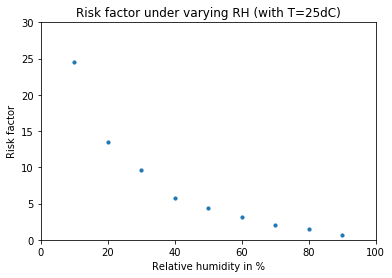

In [5]:
riskfac_array = []

for condRH in range(len(RH_range)): # Study the effect of varying RH with fixed T at 25 C
    T = 25
    RH = RH_range[condRH]
    risk_RH = module_riskfactor.riskfactor(T,RH,mode_to_test)
    riskfac_array.append(risk_RH)
plt.scatter(RH_range, riskfac_array, s=10 )
plt.axis([0, 100, 0, 30])
plt.title("Risk factor under varying RH (with T=25dC)")
plt.xlabel('Relative humidity in %')
plt.ylabel('Risk factor')
plt.show()